# ChatGPT Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/08-chatgpt.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/08-chatgpt.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/raw/master/tutorials/08-chatgpt.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

### Connect to EvaDB

In [2]:
%pip install --quiet "evadb[document,notebook,dev]"
import evadb
cursor = evadb.connect().cursor()

Note: you may need to restart the kernel to use updated packages.


## Download News Video and ChatGPT UDF 

In [3]:
# Download News Video
!wget -nc "https://www.dropbox.com/s/rfm1kds2mv77pca/russia_ukraine.mp4?dl=0" -O russia_ukraine.mp4

# Download ChatGPT UDF if needed
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/evadb/udfs/chatgpt.py -O chatgpt.py

File ‘russia_ukraine.mp4’ already there; not retrieving.
File ‘chatgpt.py’ already there; not retrieving.


### Visualize Video Frame

In [4]:
import cv2
from matplotlib import pyplot as plt

def show_video_frame(input_video_path, show_frame_number = 100):
    vcap = cv2.VideoCapture(input_video_path)
    vcap.set(1, show_frame_number) #1: CAP_PROP_POS_FRAMES    
    ret, frame = vcap.read()  # Read the frame
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)    
    plt.imshow(frame)
    plt.show()
    vcap.release()

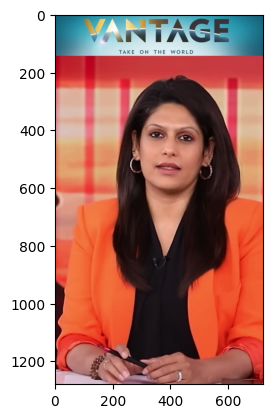

In [5]:
show_video_frame('russia_ukraine.mp4')

## Set your OpenAI API key here

In [6]:
from getpass import getpass
# Set your OpenAI key as an environment variable
import os
#os.environ['OPENAI_KEY'] = 'sk-....................'
#open_ai_key = os.environ.get('OPENAI_KEY')
open_ai_key = getpass()
os.environ['OPENAI_API_KEY'] = open_ai_key

## Run the ChatGPT UDF

![OPENAI UDF](chatgpt.png)

In [7]:
# Load the video
cursor.query("DROP TABLE IF EXISTS VIDEOS").df()
cursor.query("LOAD VIDEO 'russia_ukraine.mp4' INTO VIDEOS").df()

,0
0,Number of loaded VIDEO: 1


In [8]:
# Drop the Text Summarization UDF if needed
cursor.query("DROP FUNCTION IF EXISTS SpeechRecognizer;").df()

# Create a Text Summarization UDF using Hugging Face
text_summarizer_udf_creation = """
    CREATE FUNCTION SpeechRecognizer 
    TYPE HuggingFace 
    TASK 'automatic-speech-recognition' 
    MODEL 'openai/whisper-base';
"""
cursor.query(text_summarizer_udf_creation).df()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


,0
0,Function SpeechRecognizer added to the database.


#### Configure Pandas Display

In [9]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [10]:
# Drop the table if needed
cursor.query("DROP TABLE IF EXISTS TEXT_SUMMARY;").df()


# Create a materialized view of the text summarization output
text_summarization_query = """
    CREATE TABLE
    TEXT_SUMMARY AS 
    SELECT SpeechRecognizer(audio) FROM VIDEOS; 
"""
cursor.query(text_summarization_query).df()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


,0
0,The table TEXT_SUMMARY has been successfully created with 1 rows.


In [11]:
# Run ChatGPT over the Text Summary extracted by Whisper
chatgpt_udf = """
    SELECT ChatGPT('Is this video summary related to Ukraine russia war',text) 
    FROM TEXT_SUMMARY;
"""
cursor.query(chatgpt_udf).df()

,response
0,"Based on the context provided, the video summary is related to the war in Ukraine, but it focuses more on the involvement and profiteering of US oil companies rather than the direct conflict between Ukraine and Russia. It highlights how American oil companies are benefiting financially from the instability and conflict in Ukraine."


In [13]:
cursor.query("DROP FUNCTION IF EXISTS ChatGPTWithCache").df()

cursor.query("""
CREATE FUNCTION ChatGPTWithCache
IMPL '../evadb/functions/chatgpt_with_cache.py'
model 'gpt-3.5-turbo';
""").df()

,0
0,Function ChatGPTWithCache added to the database.


In [14]:
cursor.query("""SHOW FUNCTIONS""").df()

,name,inputs,outputs,type,impl,metadata
0,MnistImageClassifier,"[data NDARRAY ANYTYPE (3, 28, 28)]",[label TEXT],Classification,/Users/cksash/Documents/Documents - The Better Mac/proj/evadb/evadb/functions/mnist_image_classifier.py,[]
1,FastRCNNObjectDetector,"[Frame_Array NDARRAY UINT8 (3, None, None)]","[labels NDARRAY STR (None,), bboxes NDARRAY FLOAT32 (None, 4), scores NDARRAY FLOAT32 (None,)]",Classification,/Users/cksash/Documents/Documents - The Better Mac/proj/evadb/evadb/functions/fastrcnn_object_detector.py,[]
2,ArrayCount,"[Input_Array NDARRAY ANYTYPE (), Search_Key ANY]",[key_count INTEGER],NdarrayFunction,/Users/cksash/Documents/Documents - The Better Mac/proj/evadb/evadb/functions/ndarray/array_count.py,[]
3,Crop,"[Frame_Array NDARRAY UINT8 (3, None, None), bboxes NDARRAY FLOAT32 (None, 4)]","[Cropped_Frame_Array NDARRAY UINT8 (3, None, None)]",NdarrayFunction,/Users/cksash/Documents/Documents - The Better Mac/proj/evadb/evadb/functions/ndarray/crop.py,[]
4,Open,[img_path TEXT],"[data NDARRAY UINT8 (3, None, None)]",NdarrayFunction,/Users/cksash/Documents/Documents - The Better Mac/proj/evadb/evadb/functions/ndarray/open.py,[]
5,Similarity,"[Frame_Array_Open NDARRAY UINT8 (3, None, None), Frame_Array_Base NDARRAY UINT8 (3, None, None), Feature_Extractor_Name TEXT]",[distance FLOAT],NdarrayFunction,/Users/cksash/Documents/Documents - The Better Mac/proj/evadb/evadb/functions/ndarray/similarity.py,[]
6,ChatGPT,"[query NDARRAY STR (1,), content NDARRAY STR (1,), prompt NDARRAY STR (None,)]","[response NDARRAY STR (1,)]",None,/Users/cksash/Documents/Documents - The Better Mac/proj/evadb/evadb/functions/chatgpt.py,[]
7,Yolo,"[data NDARRAY FLOAT32 (None, None, 3)]","[labels NDARRAY STR (None,), bboxes NDARRAY FLOAT32 (None,), scores NDARRAY FLOAT32 (None,)]",ultralytics,/Users/cksash/Documents/Documents - The Better Mac/proj/evadb/evadb/functions/yolo_object_detector.py,"[FunctionMetadataCatalogEntry(key='model', value='yolov8m.pt', function_id=8, function_name='Yolo', row_id=1)]"
8,StableDiffusion,"[prompt NDARRAY STR (None,)]","[response NDARRAY FLOAT32 (None, None, 3)]",None,/Users/cksash/Documents/Documents - The Better Mac/proj/evadb/evadb/functions/stable_diffusion.py,[]
9,DallE,"[prompt NDARRAY STR (None,)]","[response NDARRAY FLOAT32 (None, None, 3)]",None,/Users/cksash/Documents/Documents - The Better Mac/proj/evadb/evadb/functions/dalle.py,[]


In [17]:
cursor.query("DELETE FROM TEXT_SUMMARY WHERE _row_id = 2").df()
cursor.query("INSERT INTO TEXT_SUMMARY (_row_id, text) VALUE (2, \"The war in Ukraine has been on for 415 days. Who is winning it? Not Russia. Certainly not Ukraine. It is the US oil companies. US oil companies have reached $200 billion in pure profits. The earnings are still on. They are still milking this war and sharing the spoils. Let us look at how Exxon mobile has been doing. In 2022, the company made $56 billion in profits. Oil companies capitalized on instability and they are profiting from pain. American oil companies are masters of this art. You may remember the war in Iraq. The US went to war in Iraq by selling a lie. The Americans did not find any weapons of mass destruction but they did find lots of oil. And in the year since, American officials have admitted this. And this story is not over. It's repeating itself in Ukraine. They are feeding another war and filling the coffers of US oil companies.\")").df()
cursor.query("SELECT * FROM TEXT_SUMMARY").df()

KeyboardInterrupt: 

In [ ]:
cursor.query("CREATE TABLE PROMPTS IF NOT EXISTS (text );)").df()
#cursor.query("INSERT INTO TABLE PROMPTS (text) VALUES ('Who is Sachin Tendulkar?')").df()
cursor.query("SELECT * FROM PROMPTS").df()

In [ ]:

# Run ChatGPT over the Text Summary extracted by Whisper
chatgpt_udf = """
    SELECT ChatGPTWithCache('Is this video summary related to Ukraine russia war?', text) 
    FROM TEXT_SUMMARY;
"""
from time import time 

latencies = []

start_time = time()
cursor.query(chatgpt_udf).df()
end_time = time()
latencies.append(end_time - start_time)

print (latencies)

Starting forward
Imported OpenAI
Initialized OpenAI client
Calling for prompt
Calling completion api with: {'model': 'gpt-3.5-turbo', 'temperature': 0, 'messages': [{'role': 'system', 'content': 'You are a helpful assistant that accomplishes user tasks.'}, {'role': 'user', 'content': "Here is some context :  The war in Ukraine has been on for 415 days. Who is winning it? Not Russia. Certainly not Ukraine. It is the US oil companies. US oil companies have reached $200 billion in pure profits. The earnings are still on. They are still milking this war and sharing the spoils. Let us look at how Exxon mobile has been doing. In 2022, the company made $56 billion in profits. Oil companies capitalized on instability and they are profiting from pain. American oil companies are masters of this art. You may remember the war in Iraq. The US went to war in Iraq by selling a lie. The Americans did not find any weapons of mass destruction but they did find lots of oil. And in the year since, America

## Check if it works on an SNL Video

In [12]:
# Download Entertainment Video
!wget -nc "https://www.dropbox.com/s/u66im8jw2s1dmuw/snl.mp4?dl=0" -O snl.mp4

cursor.query("DROP TABLE IF EXISTS SNL_VIDEO;").df()

cursor.query("LOAD VIDEO 'snl.mp4' INTO SNL_VIDEO;").df()

File ‘snl.mp4’ already there; not retrieving.


,0
0,Number of loaded VIDEO: 1


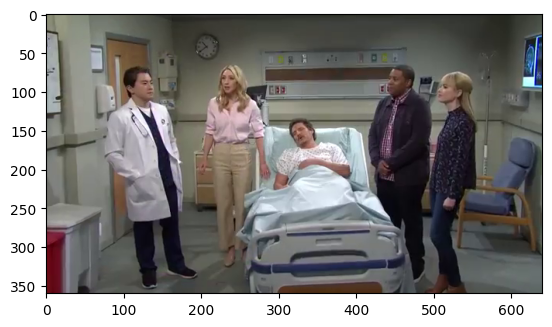

In [13]:
show_video_frame('snl.mp4')

In [14]:
# Drop the table if needed
cursor.query("DROP TABLE IF EXISTS SNL_TEXT_SUMMARY;").df()


# Create a materialized view of the text summarization output
text_summarization_query = """
    CREATE TABLE
    SNL_TEXT_SUMMARY AS 
    SELECT SpeechRecognizer(audio) FROM SNL_VIDEO;
"""
cursor.query(text_summarization_query).df()

/home/jarulraj3/eva/test_evadb/lib/python3.10/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


""


### ChatGPT: Is this video summary related to Ukraine War?

In [15]:
# Run ChatGPT over the Text Summary extracted by Whisper
chatgpt_udf = """
    SELECT ChatGPT('Is this video summary related to Ukraine russia war',text) 
    FROM SNL_TEXT_SUMMARY;
"""
cursor.query(chatgpt_udf).df()

,chatgpt.response
0,"No, this video summary is not related to the Ukraine-Russia war. It is about a man waking up from a coma and experiencing confusion and temporary changes in personality and speech."


### ChatGPT: Is this video summary related to a hospital?

In [16]:
# Run ChatGPT over the Text Summary extracted by Whisper
chatgpt_udf = """
    SELECT ChatGPT('Is this video summary related to a hospital',text) 
    FROM SNL_TEXT_SUMMARY;
"""
cursor.query(chatgpt_udf).df()

,chatgpt.response
0,"Yes, the video summary is related to a hospital. It features a doctor and a patient who has just woken up from a coma and is experiencing confusion and memory loss. The patient's wife and sister are also present, and the doctor reassures them that the patient's condition is normal and temporary. The video highlights the emotional rollercoaster that patients and their loved ones go through during a hospital stay."
